In [ ]:
!pip install catboost
!pip install shap
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 31.7 MB/s eta 0:00:00


# CatBoost 사용

In [ ]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## target 데이터 생성

In [ ]:
data_10k = pd.read_csv("/content/drive/MyDrive/비어플/25-2/model/model_below_10k_data.csv")
data_5m = pd.read_csv("/content/drive/MyDrive/비어플/25-2/model/model_upper_5M_data.csv")
data_test = pd.read_csv("/content/drive/MyDrive/비어플/25-2/model/model_test_data.csv")
data_train = pd.read_csv("/content/drive/MyDrive/비어플/25-2/model/model_train_data.csv")


10k미만을 target = 1로 정의

In [ ]:
data_10k["target"] = 1
data_5m["target"] = 0
data_test["target"] = 0
data_train["target"] = 0

In [ ]:
data_full = pd.concat([data_10k, data_5m, data_test, data_train], axis=0).reset_index(drop=True)

범주형 변수 지정

In [ ]:
cat_features = ['Grade', 'Main_Country', 'Pandemic']

## 데이터 분할

In [ ]:
movie_titles = data_full['Movie_Title']

총 관람객 수, 총 상영일수 횟수, 총 상영 주차는 종속변수이므로 제거한다

In [ ]:
X = data_full.drop(['Movie_Title', 'Total_Audience_Count', 'target', "Total_Show_Days", "Total_Weeks"], axis=1)
y = data_full['target']

In [ ]:
# target(y)를 기준으로 계층 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## CatBoost 모델 구동 (GPU 사용)

## 1) 초기 구동

In [ ]:
model = CatBoostClassifier(
    iterations=500,
    verbose=100,  # 100번마다 학습 로그 출력
    task_type='GPU',  # GPU 사용 설정
    devices='0',       # 첫 번째 GPU 사용
    cat_features=cat_features # 범주형 변수 지정
)

In [ ]:
model.fit(X_train, y_train)

Learning rate set to 0.058454
0:	learn: 0.5467814	total: 38.6ms	remaining: 19.3s
100:	learn: 0.0273081	total: 3.4s	remaining: 13.4s
200:	learn: 0.0172101	total: 6.79s	remaining: 10.1s
300:	learn: 0.0125240	total: 10.2s	remaining: 6.72s
400:	learn: 0.0100202	total: 13.5s	remaining: 3.34s
499:	learn: 0.0085969	total: 16.7s	remaining: 0us


In [ ]:
predictions = model.predict(X_test)
prediction_probs = model.predict_proba(X_test)[:, 1] # 1이 될 확률

In [ ]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Probability_of_Success': prediction_probs
})

In [ ]:
test_titles = movie_titles.loc[X_test.index]
results_df['Movie_Title'] = test_titles.values

In [ ]:
print(results_df.head())

      Actual  Predicted  Probability_of_Success Movie_Title
2998       0          0                0.000103        대병소장
3862       0          0                0.000075   메리와 마녀의 꽃
2760       0          0                0.002421     캡틴 판타스틱
2867       0          0                0.000138     페인티드 베일
2752       0          0                0.000102        가루지기


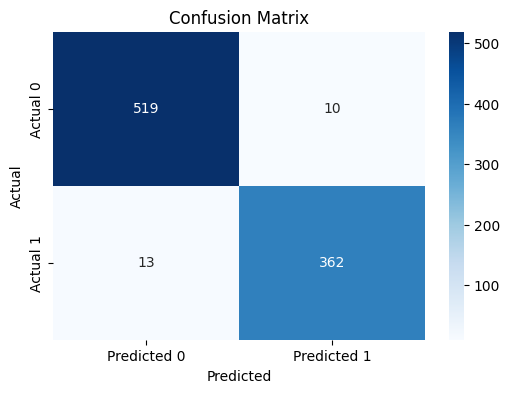

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(results_df['Actual'], results_df['Predicted'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
misclassified_movies = results_df[results_df['Actual'] != results_df['Predicted']]
pd.merge(data_full[data_full["Movie_Title"].isin(misclassified_movies['Movie_Title'].tolist())][["Movie_Title", "Total_Audience_Count"]], misclassified_movies)

,Movie_Title,Total_Audience_Count,Actual,Predicted,Probability_of_Success
0,나의 피투성이 연인,9369,1,0,0.148749
1,더 미드와이프,8828,1,0,0.482392
2,두 번째 스물,9579,1,0,0.477540
3,매직 스쿨: 초보마법사 아우라의 대모험,9308,1,0,0.029738
4,메리 크리스마스,5805,1,0,0.242533
5,반두비,7606,1,0,0.482165
6,쉐프,8724,1,0,0.308684
7,쓰리 세컨즈,9477,1,0,0.446670
8,오! 마이 고스트,9754,1,0,0.474886
9,제로베이스원 더 퍼스트 투어 [타임리스 월드] 인 시네마,8687,1,0,0.259423


## 2) 변수의 중요도

### get_feature_importance

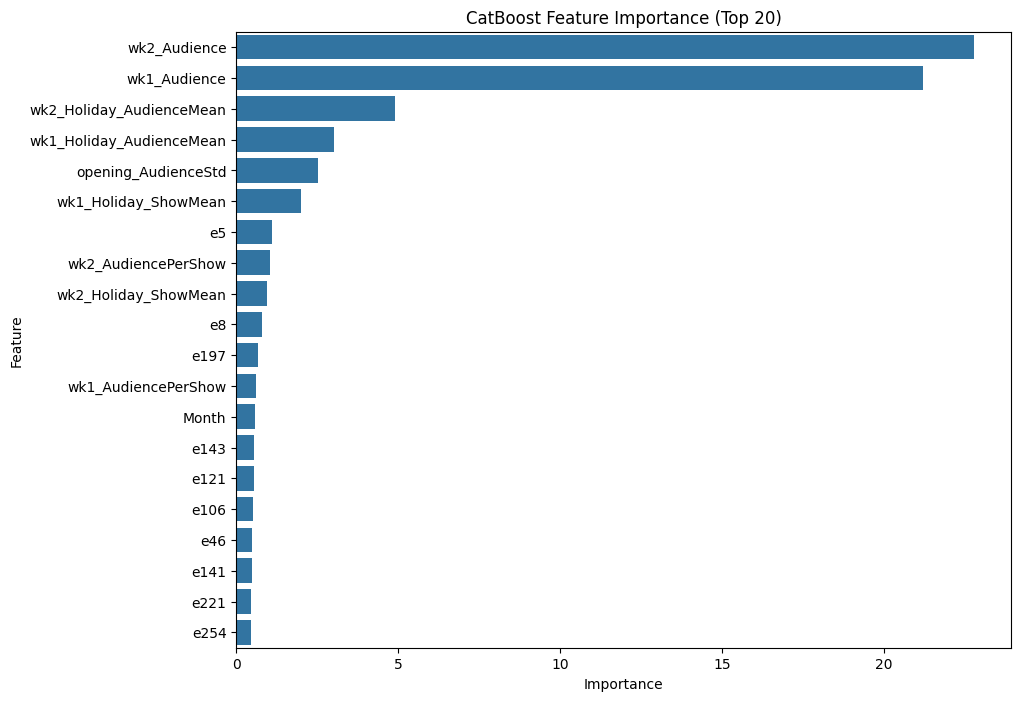

                      Feature  Importance
2                wk2_Audience   22.793273
0                wk1_Audience   21.219333
8    wk2_Holiday_AudienceMean    4.892265
6    wk1_Holiday_AudienceMean    3.019885
10        opening_AudienceStd    2.528721
7        wk1_Holiday_ShowMean    1.988132
24                         e5    1.106097
3         wk2_AudiencePerShow    1.031199
9        wk2_Holiday_ShowMean    0.951501
27                         e8    0.791605
216                      e197    0.667093
1         wk1_AudiencePerShow    0.602454
12                      Month    0.589250
162                      e143    0.550536
140                      e121    0.542795
125                      e106    0.524564
65                        e46    0.494176
160                      e141    0.474922
240                      e221    0.465898
273                      e254    0.457376


In [ ]:
# 1. 변수 중요도 추출
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# 2. 데이터프레임으로 만들기
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 3. 상위 20개 변수 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('CatBoost Feature Importance (Top 20)')
plt.show()

# 4. 중요도 출력
print(importance_df.head(20))

### SHAP

In [ ]:
import shap

# 모델과 데이터를 사용하여 explainer 객체 생성
explainer = shap.TreeExplainer(model)

# SHAP value 계산 (테스트 데이터셋에 대해 계산하는 것이 일반적)
shap_values = explainer.shap_values(X_test)

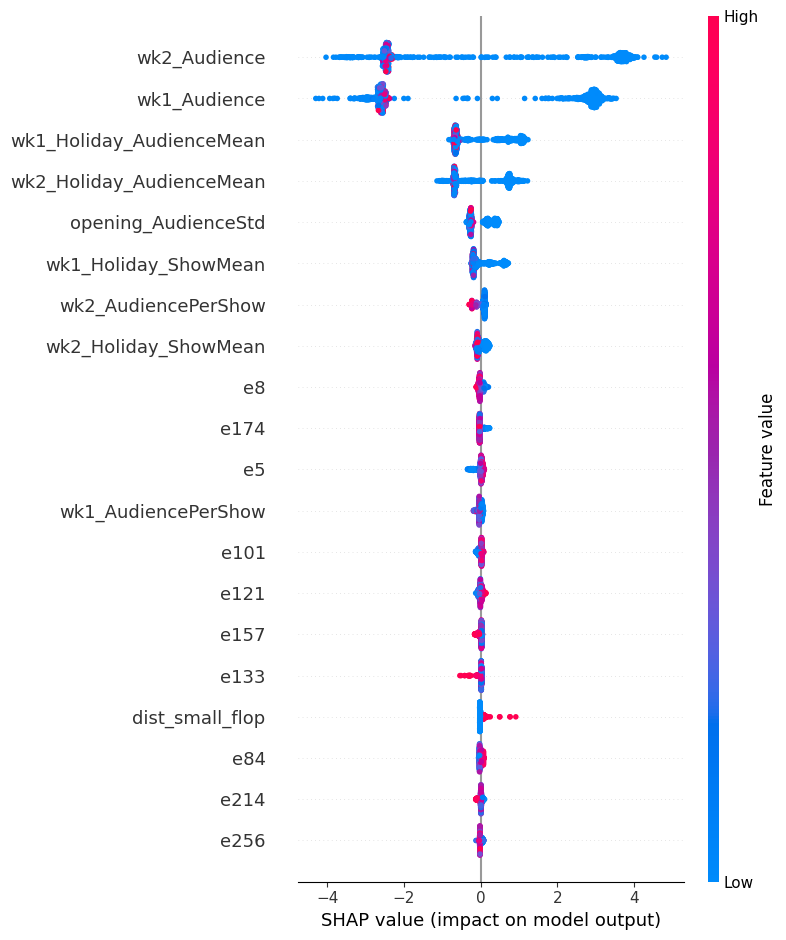

In [ ]:
# SHAP 요약 플롯 (Summary Plot)
# 모델 전체에서 각 변수가 예측에 미치는 영향의 크기와 방향을 보여줍니다.
shap.summary_plot(shap_values, X_test)

### 결론

1. `wk1_Audience`, `wk2_Audience`, `wk1_Holiday_AudienceMean`, `wk2_Holiday_AudienceMean`,    
2. `opening_AudienceStd`, `wk1_Holiday_ShowMean`, `wk2_Holiday_ShowMean`, `wk2_AudiencePerShow`  
3. `wk1_AudiencePerShow`, `dist_small_flop`  
<br>
총 4+4+2개의 변수가 유의

임베딩 변수는 별로 유의하지 않아보인다. 임베딩 차원을 줄인다면 달라질수도?

## 3) 변수 선택 후 재기동 및 하이퍼파라미터 튜닝

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score
import optuna
import warnings
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [ ]:
# Optuna의 로그 출력을 간소화
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')

In [ ]:
print(list(X_train.columns))

['wk1_Audience', 'wk1_AudiencePerShow', 'wk2_Audience', 'wk2_AudiencePerShow', 'Show_Change', 'opening_Ho_Retention', 'wk1_Holiday_AudienceMean', 'wk1_Holiday_ShowMean', 'wk2_Holiday_AudienceMean', 'wk2_Holiday_ShowMean', 'opening_AudienceStd', 'Year', 'Month', 'Pandemic', 'dist_big_flop', 'dist_big_hit', 'dist_small_flop', 'dist_small_hit', 'Grade', 'Main_Country', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12', 'e13', 'e14', 'e15', 'e16', 'e17', 'e18', 'e19', 'e20', 'e21', 'e22', 'e23', 'e24', 'e25', 'e26', 'e27', 'e28', 'e29', 'e30', 'e31', 'e32', 'e33', 'e34', 'e35', 'e36', 'e37', 'e38', 'e39', 'e40', 'e41', 'e42', 'e43', 'e44', 'e45', 'e46', 'e47', 'e48', 'e49', 'e50', 'e51', 'e52', 'e53', 'e54', 'e55', 'e56', 'e57', 'e58', 'e59', 'e60', 'e61', 'e62', 'e63', 'e64', 'e65', 'e66', 'e67', 'e68', 'e69', 'e70', 'e71', 'e72', 'e73', 'e74', 'e75', 'e76', 'e77', 'e78', 'e79', 'e80', 'e81', 'e82', 'e83', 'e84', 'e85', 'e86', 'e87', 'e88', 'e89', 'e90', 'e91', 'e9

In [ ]:
feature_sets = {
    "base_4": ['wk1_Audience', 'wk2_Audience', 'wk1_Holiday_AudienceMean', 'wk2_Holiday_AudienceMean'],
    "medium_8": ['wk1_Audience', 'wk2_Audience', 'wk1_Holiday_AudienceMean', 'wk2_Holiday_AudienceMean',
                 'opening_AudienceStd', 'wk1_Holiday_ShowMean', 'wk2_Holiday_ShowMean', 'wk2_AudiencePerShow'],
    "full_10": ['wk1_Audience', 'wk2_Audience', 'wk1_Holiday_AudienceMean', 'wk2_Holiday_AudienceMean',
                'opening_AudienceStd', 'wk1_Holiday_ShowMean', 'wk2_Holiday_ShowMean', 'wk2_AudiencePerShow',
                'wk1_AudiencePerShow', 'dist_small_flop']
}

embedding_sets = {
    "embed_128": [f'e{i+1}' for i in range(128)],
    "embed_64": [f'e{i+1}' for i in range(64)],
    "embed_32": [f'e{i+1}' for i in range(32)],
    "embed_none" : []
}

tuner_methods = ['optuna', 'random_search']
# tuner_methods = ['random_search', 'optuna']

In [ ]:
results = []
experiment_id = 0
total_experiments = len(feature_sets) * len(embedding_sets) * len(tuner_methods)

for f_name, f_cols in feature_sets.items():
    for e_name, e_cols in embedding_sets.items():

        # 현재 조합에 사용할 전체 변수 리스트 생성
        current_cols = f_cols + e_cols
        X_train_exp = X_train[current_cols]
        X_test_exp = X_test[current_cols]

        for tuner in tuner_methods:
            experiment_id += 1
            print(f"--- 실험 {experiment_id}/{total_experiments} 진행 중 ---")
            print(f"Features: {f_name}, Embeddings: {e_name}, Tuner: {tuner}")

            best_params = {}

            if tuner == 'optuna':
                def objective(trial):
                    param_optuna = {
                        'objective': 'Logloss',
                        'iterations': 300,
                        'verbose' : 0,
                        'task_type': 'GPU',
                        'devices': '0',
                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                        'depth': trial.suggest_int('depth', 4, 10),
                        'bootstrap_type': 'Bernoulli',
                        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),
                        'random_strength': trial.suggest_float('random_strength', 1e-9, 10, log=True),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient'])
                    }
                    model = CatBoostClassifier(**param_optuna)
                    score = cross_val_score(model, X_train_exp, y_train, cv=3, scoring='f1_macro').mean()
                    return score

                study = optuna.create_study(direction='maximize')
                study.optimize(objective, n_trials=40, show_progress_bar=True)
                best_params = study.best_params

            elif tuner == 'random_search':
                param_random = {
                     # --- Optuna와 동일하게 확장된 하이퍼파라미터 ---
                    'learning_rate': uniform(0.01, 0.29), # 0.01부터 0.3까지 (uniform 분포)
                    'depth': randint(4, 11), # 4부터 10까지 (정수)
                    'bootstrap_type': ['Bernoulli'],
                    'subsample': uniform(0.6, 0.4), # 0.6부터 1.0까지
                    'l2_leaf_reg': uniform(1, 9), # 1부터 10까지
                    'random_strength': uniform(1, 9), # 1부터 10까지 (log 분포 대신 uniform 사용)
                    'min_child_samples': randint(5, 101), # 5부터 100까지
                    'leaf_estimation_method': ['Newton', 'Gradient']
                }
                model = CatBoostClassifier(objective='Logloss', iterations=300, verbose=0, task_type='GPU', devices='0')
                random_search = RandomizedSearchCV(
                    model,
                    param_distributions=param_random,
                    n_iter=40,
                    cv=3,
                    scoring='f1_macro',
                    random_state=42,
                    verbose=1,
                )
                random_search.fit(X_train_exp, y_train)
                best_params = random_search.best_params_

            # 찾은 최적의 파라미터로 최종 모델 학습
            print(f"{f_name} - {e_name} - {tuner} 최종 모델 학습")
            if 'subsample' in best_params:
                best_params['bootstrap_type'] = 'Bernoulli'
            final_model = CatBoostClassifier(
                objective='Logloss',
                iterations=1000,
                verbose=200,
                task_type='GPU',
                devices='0',
                **best_params
            )
            final_model.fit(X_train_exp, y_train)

            # 테스트 데이터로 성능 평가
            preds = final_model.predict(X_test_exp)
            f1 = f1_score(y_test, preds, average='macro')
            accuracy = accuracy_score(y_test, preds)

            # 결과 저장
            results.append({
                "Experiment_ID": experiment_id,
                "Feature_Set": f_name,
                "Embedding_Set": e_name,
                "Tuner": tuner,
                "Test_F1_Macro": f1,
                "Test_Accuracy": accuracy,
                "Best_Params": best_params
            })
            print(f"결과 - F1 Macro: {f1:.4f}, Accuracy: {accuracy:.4f}\n")

--- 실험 1/24 진행 중 ---
Features: base_4, Embeddings: embed_128, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_4 - embed_128 - optuna 최종 모델 학습
0:	learn: 0.5801603	total: 32ms	remaining: 31.9s
200:	learn: 0.0193844	total: 6.16s	remaining: 24.5s
400:	learn: 0.0127529	total: 12.3s	remaining: 18.3s
600:	learn: 0.0097449	total: 18.4s	remaining: 12.2s
800:	learn: 0.0084910	total: 24.5s	remaining: 6.08s
999:	learn: 0.0075643	total: 30.5s	remaining: 0us
결과 - F1 Macro: 0.9681, Accuracy: 0.9690

--- 실험 2/24 진행 중 ---
Features: base_4, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_4 - embed_128 - random_search 최종 모델 학습
0:	learn: 0.3504044	total: 32.1ms	remaining: 32s
200:	learn: 0.0016617	total: 45.9s	remaining: 3m 2s
400:	learn: 0.0008443	total: 1m 31s	remaining: 2m 16s
600:	learn: 0.0007148	total: 2m 16s	remaining: 1m 30s
800:	learn: 0.0006356	total: 3m 1s	remaining: 45.1s
999:	learn: 0.0005640	total: 3m 41s	remaining: 0us
결과 - F1 Macro: 0.9704, Accuracy: 0.9712

--- 실험 3/24 진행 중 ---
Features: base_4, Embeddings: embed_64, Tuner: optun

  0%|          | 0/40 [00:00<?, ?it/s]

base_4 - embed_64 - optuna 최종 모델 학습
0:	learn: 0.6652653	total: 13.9ms	remaining: 13.9s
200:	learn: 0.0505202	total: 2.83s	remaining: 11.3s
400:	learn: 0.0340700	total: 5.65s	remaining: 8.44s
600:	learn: 0.0253155	total: 8.47s	remaining: 5.63s
800:	learn: 0.0198188	total: 11.4s	remaining: 2.82s
999:	learn: 0.0162922	total: 14.3s	remaining: 0us
결과 - F1 Macro: 0.9692, Accuracy: 0.9701

--- 실험 4/24 진행 중 ---
Features: base_4, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_4 - embed_64 - random_search 최종 모델 학습
0:	learn: 0.5151963	total: 30.2ms	remaining: 30.2s
200:	learn: 0.0141467	total: 6.38s	remaining: 25.4s
400:	learn: 0.0083052	total: 12.4s	remaining: 18.6s
600:	learn: 0.0065754	total: 18.4s	remaining: 12.2s
800:	learn: 0.0053268	total: 24.3s	remaining: 6.04s
999:	learn: 0.0047058	total: 30.5s	remaining: 0us
결과 - F1 Macro: 0.9693, Accuracy: 0.9701

--- 실험 5/24 진행 중 ---
Features: base_4, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_4 - embed_32 - optuna 최종 모델 학습
0:	learn: 0.6256188	total: 30.5ms	remaining: 30.4s
200:	learn: 0.0302726	total: 5.86s	remaining: 23.3s
400:	learn: 0.0187555	total: 11.7s	remaining: 17.5s
600:	learn: 0.0141613	total: 17.5s	remaining: 11.6s
800:	learn: 0.0117662	total: 23.6s	remaining: 5.86s
999:	learn: 0.0104277	total: 29.4s	remaining: 0us
결과 - F1 Macro: 0.9727, Accuracy: 0.9735

--- 실험 6/24 진행 중 ---
Features: base_4, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_4 - embed_32 - random_search 최종 모델 학습
0:	learn: 0.3721297	total: 34.8ms	remaining: 34.8s
200:	learn: 0.0019169	total: 10.9s	remaining: 43.3s
400:	learn: 0.0008863	total: 21.9s	remaining: 32.7s
600:	learn: 0.0005180	total: 32.8s	remaining: 21.8s
800:	learn: 0.0004080	total: 43.7s	remaining: 10.9s
999:	learn: 0.0003445	total: 54.6s	remaining: 0us
결과 - F1 Macro: 0.9749, Accuracy: 0.9757

--- 실험 7/24 진행 중 ---
Features: base_4, Embeddings: embed_none, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_4 - embed_none - optuna 최종 모델 학습
0:	learn: 0.6767646	total: 31.1ms	remaining: 31.1s
200:	learn: 0.0792832	total: 6.03s	remaining: 24s
400:	learn: 0.0547442	total: 11.8s	remaining: 17.6s
600:	learn: 0.0474210	total: 17.7s	remaining: 11.7s
800:	learn: 0.0435614	total: 23.4s	remaining: 5.82s
999:	learn: 0.0410163	total: 29.5s	remaining: 0us
결과 - F1 Macro: 0.9715, Accuracy: 0.9723

--- 실험 8/24 진행 중 ---
Features: base_4, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_4 - embed_none - random_search 최종 모델 학습
0:	learn: 0.6579668	total: 13.2ms	remaining: 13.2s
200:	learn: 0.0474605	total: 5.53s	remaining: 22s
400:	learn: 0.0398013	total: 11.2s	remaining: 16.7s
600:	learn: 0.0355334	total: 16.7s	remaining: 11.1s
800:	learn: 0.0323469	total: 22.1s	remaining: 5.48s
999:	learn: 0.0297568	total: 27.6s	remaining: 0us
결과 - F1 Macro: 0.9715, Accuracy: 0.9723

--- 실험 9/24 진행 중 ---
Features: medium_8, Embeddings: embed_128, Tuner: optu

  0%|          | 0/40 [00:00<?, ?it/s]

medium_8 - embed_128 - optuna 최종 모델 학습
0:	learn: 0.5384101	total: 22.7ms	remaining: 22.7s
200:	learn: 0.0119185	total: 4.46s	remaining: 17.7s
400:	learn: 0.0070361	total: 8.89s	remaining: 13.3s
600:	learn: 0.0051735	total: 13.3s	remaining: 8.82s
800:	learn: 0.0042605	total: 17.6s	remaining: 4.38s
999:	learn: 0.0036983	total: 22s	remaining: 0us
결과 - F1 Macro: 0.9681, Accuracy: 0.9690

--- 실험 10/24 진행 중 ---
Features: medium_8, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_8 - embed_128 - random_search 최종 모델 학습
0:	learn: 0.5741512	total: 31.8ms	remaining: 31.8s
200:	learn: 0.0190877	total: 6.13s	remaining: 24.3s
400:	learn: 0.0120734	total: 12.1s	remaining: 18s
600:	learn: 0.0100935	total: 18.1s	remaining: 12s
800:	learn: 0.0087126	total: 24.1s	remaining: 5.98s
999:	learn: 0.0082693	total: 30.1s	remaining: 0us
결과 - F1 Macro: 0.9681, Accuracy: 0.9690

--- 실험 11/24 진행 중 ---
Features: medium_8, Embeddings: embed_64, Tuner: op

  0%|          | 0/40 [00:00<?, ?it/s]

medium_8 - embed_64 - optuna 최종 모델 학습
0:	learn: 0.6299961	total: 32.1ms	remaining: 32.1s
200:	learn: 0.0267277	total: 6s	remaining: 23.8s
400:	learn: 0.0166860	total: 11.9s	remaining: 17.7s
600:	learn: 0.0134806	total: 17.9s	remaining: 11.9s
800:	learn: 0.0117086	total: 23.8s	remaining: 5.91s
999:	learn: 0.0095488	total: 29.8s	remaining: 0us
결과 - F1 Macro: 0.9715, Accuracy: 0.9723

--- 실험 12/24 진행 중 ---
Features: medium_8, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_8 - embed_64 - random_search 최종 모델 학습
0:	learn: 0.4620231	total: 33.1ms	remaining: 33.1s
200:	learn: 0.0069937	total: 6.77s	remaining: 26.9s
400:	learn: 0.0047012	total: 13.5s	remaining: 20.2s
600:	learn: 0.0034747	total: 19.7s	remaining: 13.1s
800:	learn: 0.0028644	total: 25.9s	remaining: 6.43s
999:	learn: 0.0027632	total: 32.2s	remaining: 0us
결과 - F1 Macro: 0.9715, Accuracy: 0.9723

--- 실험 13/24 진행 중 ---
Features: medium_8, Embeddings: embed_32, Tuner: op

  0%|          | 0/40 [00:00<?, ?it/s]

medium_8 - embed_32 - optuna 최종 모델 학습
0:	learn: 0.5192692	total: 14.9ms	remaining: 14.9s
200:	learn: 0.0128518	total: 2.73s	remaining: 10.9s
400:	learn: 0.0062498	total: 5.47s	remaining: 8.17s
600:	learn: 0.0043806	total: 8.23s	remaining: 5.46s
800:	learn: 0.0033732	total: 11s	remaining: 2.73s
999:	learn: 0.0028044	total: 13.8s	remaining: 0us
결과 - F1 Macro: 0.9716, Accuracy: 0.9723

--- 실험 14/24 진행 중 ---
Features: medium_8, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_8 - embed_32 - random_search 최종 모델 학습
0:	learn: 0.3492118	total: 14.7ms	remaining: 14.7s
200:	learn: 0.0015981	total: 37.9s	remaining: 2m 30s
400:	learn: 0.0007430	total: 1m 16s	remaining: 1m 54s
600:	learn: 0.0005163	total: 1m 54s	remaining: 1m 16s
800:	learn: 0.0004002	total: 2m 33s	remaining: 38.1s
999:	learn: 0.0003214	total: 3m 11s	remaining: 0us
결과 - F1 Macro: 0.9715, Accuracy: 0.9723

--- 실험 15/24 진행 중 ---
Features: medium_8, Embeddings: embed_none,

  0%|          | 0/40 [00:00<?, ?it/s]

medium_8 - embed_none - optuna 최종 모델 학습
0:	learn: 0.6625283	total: 15ms	remaining: 15s
200:	learn: 0.0441332	total: 15.1s	remaining: 1m
400:	learn: 0.0320961	total: 33.6s	remaining: 50.3s
600:	learn: 0.0254810	total: 52.5s	remaining: 34.8s
800:	learn: 0.0205455	total: 1m 11s	remaining: 17.7s
999:	learn: 0.0168747	total: 1m 29s	remaining: 0us
결과 - F1 Macro: 0.9749, Accuracy: 0.9757

--- 실험 16/24 진행 중 ---
Features: medium_8, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_8 - embed_none - random_search 최종 모델 학습
0:	learn: 0.5622598	total: 41.1ms	remaining: 41s
200:	learn: 0.0149617	total: 18.2s	remaining: 1m 12s
400:	learn: 0.0075273	total: 37.7s	remaining: 56.2s
600:	learn: 0.0051831	total: 57.1s	remaining: 37.9s
800:	learn: 0.0040035	total: 1m 16s	remaining: 19s
999:	learn: 0.0031660	total: 1m 35s	remaining: 0us
결과 - F1 Macro: 0.9726, Accuracy: 0.9735

--- 실험 17/24 진행 중 ---
Features: full_10, Embeddings: embed_128, Tuner:

  0%|          | 0/40 [00:00<?, ?it/s]

full_10 - embed_128 - optuna 최종 모델 학습
0:	learn: 0.2538188	total: 13.9ms	remaining: 13.8s
200:	learn: 0.0083632	total: 2.55s	remaining: 10.1s
400:	learn: 0.0054828	total: 5.13s	remaining: 7.66s
600:	learn: 0.0041442	total: 7.73s	remaining: 5.13s
800:	learn: 0.0031391	total: 10.3s	remaining: 2.55s
999:	learn: 0.0024189	total: 12.8s	remaining: 0us
결과 - F1 Macro: 0.9693, Accuracy: 0.9701

--- 실험 18/24 진행 중 ---
Features: full_10, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_10 - embed_128 - random_search 최종 모델 학습
0:	learn: 0.5021996	total: 51.1ms	remaining: 51.1s
200:	learn: 0.0056586	total: 12.8s	remaining: 51s
400:	learn: 0.0038498	total: 25.9s	remaining: 38.6s
600:	learn: 0.0030731	total: 38.8s	remaining: 25.8s
800:	learn: 0.0024421	total: 51.7s	remaining: 12.8s
999:	learn: 0.0022026	total: 1m 4s	remaining: 0us
결과 - F1 Macro: 0.9715, Accuracy: 0.9723

--- 실험 19/24 진행 중 ---
Features: full_10, Embeddings: embed_64, Tuner: op

  0%|          | 0/40 [00:00<?, ?it/s]

full_10 - embed_64 - optuna 최종 모델 학습
0:	learn: 0.5062532	total: 31.7ms	remaining: 31.7s
200:	learn: 0.0120320	total: 6.2s	remaining: 24.6s
400:	learn: 0.0078871	total: 12.1s	remaining: 18s
600:	learn: 0.0064716	total: 18.1s	remaining: 12s
800:	learn: 0.0057918	total: 24s	remaining: 5.96s
999:	learn: 0.0049801	total: 30s	remaining: 0us
결과 - F1 Macro: 0.9715, Accuracy: 0.9723

--- 실험 20/24 진행 중 ---
Features: full_10, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_10 - embed_64 - random_search 최종 모델 학습
0:	learn: 0.5157213	total: 31.8ms	remaining: 31.7s
200:	learn: 0.0125642	total: 5.94s	remaining: 23.6s
400:	learn: 0.0078496	total: 12s	remaining: 17.9s
600:	learn: 0.0058867	total: 17.9s	remaining: 11.9s
800:	learn: 0.0044300	total: 23.8s	remaining: 5.91s
999:	learn: 0.0040310	total: 29.6s	remaining: 0us
결과 - F1 Macro: 0.9693, Accuracy: 0.9701

--- 실험 21/24 진행 중 ---
Features: full_10, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_10 - embed_32 - optuna 최종 모델 학습
0:	learn: 0.3949533	total: 21.3ms	remaining: 21.3s
200:	learn: 0.0045826	total: 3.95s	remaining: 15.7s
400:	learn: 0.0027902	total: 7.87s	remaining: 11.8s
600:	learn: 0.0020077	total: 11.8s	remaining: 7.84s
800:	learn: 0.0015296	total: 15.7s	remaining: 3.91s
999:	learn: 0.0013021	total: 19.7s	remaining: 0us
결과 - F1 Macro: 0.9727, Accuracy: 0.9735

--- 실험 22/24 진행 중 ---
Features: full_10, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_10 - embed_32 - random_search 최종 모델 학습
0:	learn: 0.5770936	total: 34.3ms	remaining: 34.3s
200:	learn: 0.0209994	total: 6.21s	remaining: 24.7s
400:	learn: 0.0113139	total: 12.4s	remaining: 18.6s
600:	learn: 0.0085843	total: 18.5s	remaining: 12.3s
800:	learn: 0.0073929	total: 24.5s	remaining: 6.08s
999:	learn: 0.0063844	total: 30.4s	remaining: 0us
결과 - F1 Macro: 0.9715, Accuracy: 0.9723

--- 실험 23/24 진행 중 ---
Features: full_10, Embeddings: embed_none, Tuner: o

  0%|          | 0/40 [00:00<?, ?it/s]

full_10 - embed_none - optuna 최종 모델 학습
0:	learn: 0.6651129	total: 13ms	remaining: 13s
200:	learn: 0.0532473	total: 2.39s	remaining: 9.5s
400:	learn: 0.0429999	total: 4.78s	remaining: 7.13s
600:	learn: 0.0387219	total: 7.16s	remaining: 4.75s
800:	learn: 0.0355923	total: 9.55s	remaining: 2.37s
999:	learn: 0.0331309	total: 12s	remaining: 0us
결과 - F1 Macro: 0.9737, Accuracy: 0.9746

--- 실험 24/24 진행 중 ---
Features: full_10, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_10 - embed_none - random_search 최종 모델 학습
0:	learn: 0.6291476	total: 61.3ms	remaining: 1m 1s
200:	learn: 0.0351712	total: 20.1s	remaining: 1m 19s
400:	learn: 0.0131660	total: 1m 13s	remaining: 1m 49s
600:	learn: 0.0074249	total: 2m 18s	remaining: 1m 32s
800:	learn: 0.0056593	total: 3m 24s	remaining: 50.8s
999:	learn: 0.0046572	total: 4m 30s	remaining: 0us
결과 - F1 Macro: 0.9738, Accuracy: 0.9746



In [ ]:
# --- 4. 최종 결과 취합 및 출력 ---
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='Test_F1_Macro', ascending=False)

print("========== 최종 실험 결과 (F1 Score 기준 정렬) ==========")
print(results_df_sorted)

========== 최종 실험 결과 (F1 Score 기준 정렬) ==========
    Experiment_ID Feature_Set Embedding_Set          Tuner  Test_F1_Macro  \
5               6      base_4      embed_32  random_search       0.974936   
14             15    medium_8    embed_none         optuna       0.974917   
23             24     full_10    embed_none  random_search       0.973787   
22             23     full_10    embed_none         optuna       0.973745   
20             21     full_10      embed_32         optuna       0.972679   
4               5      base_4      embed_32         optuna       0.972658   
15             16    medium_8    embed_none  random_search       0.972636   
12             13    medium_8      embed_32         optuna       0.971551   
7               8      base_4    embed_none  random_search       0.971530   
17             18     full_10     embed_128  random_search       0.971507   
18             19     full_10      embed_64         optuna       0.971507   
10             11    medium_

|Experiment_ID|Feature_Set|Embedding_Set|Test_F1_Macro|Tuner|Test_Accuracy|  
|---|---|---|---|---|---|  
|9|medium_8|embed_128|optuna|0.976047|0.976770|

## 최종 모델 생성

In [ ]:
# 5-1. 가장 점수가 높았던 실험의 설정 가져오기
best_experiment = results_df_sorted.iloc[0]
best_f_name = best_experiment['Feature_Set']
best_e_name = best_experiment['Embedding_Set']
best_params = best_experiment['Best_Params']

print(f"최고 성능 조합: Features='{best_f_name}', Embeddings='{best_e_name}'")
print(f"최고 성능 하이퍼파라미터: {best_params}")

# 5-2. 최고 성능 조합에 맞는 데이터 다시 준비
best_f_cols = feature_sets[best_f_name]
best_e_cols = embedding_sets[best_e_name]
best_current_cols = best_f_cols + best_e_cols

# 전체 학습 데이터(X_train + X_test)를 사용
X_train_best = X[best_current_cols].copy()

# 5-3. 최고 성능 파라미터로 최종 모델 생성 및 학습
if 'subsample' in best_params:
    best_params['bootstrap_type'] = 'Bernoulli'

best_model = CatBoostClassifier(
    objective='Logloss',
    iterations=1000, # 최종 모델이므로 반복 횟수를 충분히 설정
    verbose=200,
    task_type='GPU',
    devices='0',
    **best_params
)

print("\n최고 성능 모델 재학습 시작...")
best_model.fit(X_train_best, y) #y_train 대신 y
print("재학습 완료.")

# 5-4. 모델 파일로 저장
best_model.save_model("/content/drive/MyDrive/비어플/25-2/model/catboost_model_10k.cbm")
print("최고 성능 모델을 'best_catboost_model.cbm' 파일로 저장했습니다. 💾")

최고 성능 조합: Features='base_4', Embeddings='embed_32'
최고 성능 하이퍼파라미터: {'bootstrap_type': 'Bernoulli', 'depth': 8, 'l2_leaf_reg': np.float64(4.887505167779041), 'leaf_estimation_method': 'Newton', 'learning_rate': np.float64(0.16218465147493286), 'min_child_samples': 46, 'random_strength': np.float64(1.419990968922539), 'subsample': np.float64(0.9895022075365837)}

최고 성능 모델 재학습 시작...
0:	learn: 0.3708874	total: 34.9ms	remaining: 34.8s
200:	learn: 0.0035068	total: 11s	remaining: 43.9s
400:	learn: 0.0022195	total: 22.1s	remaining: 33s
600:	learn: 0.0011950	total: 33.2s	remaining: 22s
800:	learn: 0.0008794	total: 44.3s	remaining: 11s
999:	learn: 0.0006747	total: 55.3s	remaining: 0us
재학습 완료.
최고 성능 모델을 'best_catboost_model.cbm' 파일로 저장했습니다. 💾


# LightGBM 사용

## 초기 구동

In [ ]:
import lightgbm as lgb

In [ ]:
model = lgb.LGBMClassifier(
    n_estimators=500,     # iterations -> n_estimators
    device='gpu',         # task_type -> device
    gpu_device_id=0,      # devices -> gpu_device_id
    random_state=42       # 결과 재현을 위한 random_state 추가 (권장)
)

In [ ]:
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [ ]:
model.fit(
    X_train,
    y_train,
    categorical_feature=cat_features,              # cat_features -> categorical_feature
    callbacks=[lgb.log_evaluation(period=100)]     # verbose -> callbacks
)

[LightGBM] [Info] Number of positive: 1501, number of negative: 2112
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 68126
[LightGBM] [Info] Number of data points in the train set: 3613, number of used features: 276
[LightGBM] [Info] Using GPU Device: NVIDIA L4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 273 dense feature groups (0.95 MB) transferred to GPU in 0.002709 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.415444 -> initscore=-0.341504
[LightGBM] [Info] Start training from score -0.341504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

LGBMClassifier(device='gpu', gpu_device_id=0, n_estimators=500, random_state=42)

In [ ]:
predictions = model.predict(X_test)
prediction_probs = model.predict_proba(X_test)[:, 1] # 1이 될 확률

In [ ]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Probability_of_Success': prediction_probs
})
test_titles = movie_titles.loc[X_test.index]
results_df['Movie_Title'] = test_titles.values

results_df.head()

,Actual,Predicted,Probability_of_Success,Movie_Title
2998,0,0,7.964189e-09,대병소장
3862,0,0,1.515317e-09,메리와 마녀의 꽃
2760,0,0,1.169855e-08,캡틴 판타스틱
2867,0,0,1.719379e-09,페인티드 베일
2752,0,0,9.084061e-09,가루지기


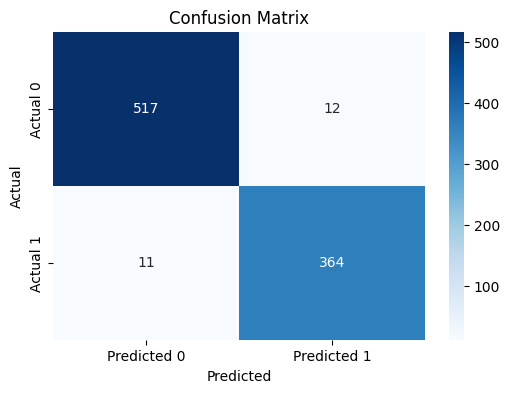

In [ ]:
cm = confusion_matrix(results_df['Actual'], results_df['Predicted'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
misclassified_movies = results_df[results_df['Actual'] != results_df['Predicted']]
pd.merge(data_full[data_full["Movie_Title"].isin(misclassified_movies['Movie_Title'].tolist())][["Movie_Title", "Total_Audience_Count"]], misclassified_movies)

,Movie_Title,Total_Audience_Count,Actual,Predicted,Probability_of_Success
0,나의 피투성이 연인,9369,1,0,0.036211
1,두 번째 스물,9579,1,0,0.204761
2,매직 스쿨: 초보마법사 아우라의 대모험,9308,1,0,0.000003
3,메리 크리스마스,5805,1,0,0.062834
4,범죄소년,9082,1,0,0.042331
5,사물의 비밀,7546,1,0,0.044488
6,오! 마이 고스트,9754,1,0,0.145940
7,제로베이스원 더 퍼스트 투어 [타임리스 월드] 인 시네마,8687,1,0,0.000790
8,쿵푸 보이,8859,1,0,0.004114
9,킹 리차드,9793,1,0,0.000349


## 변수 중요도

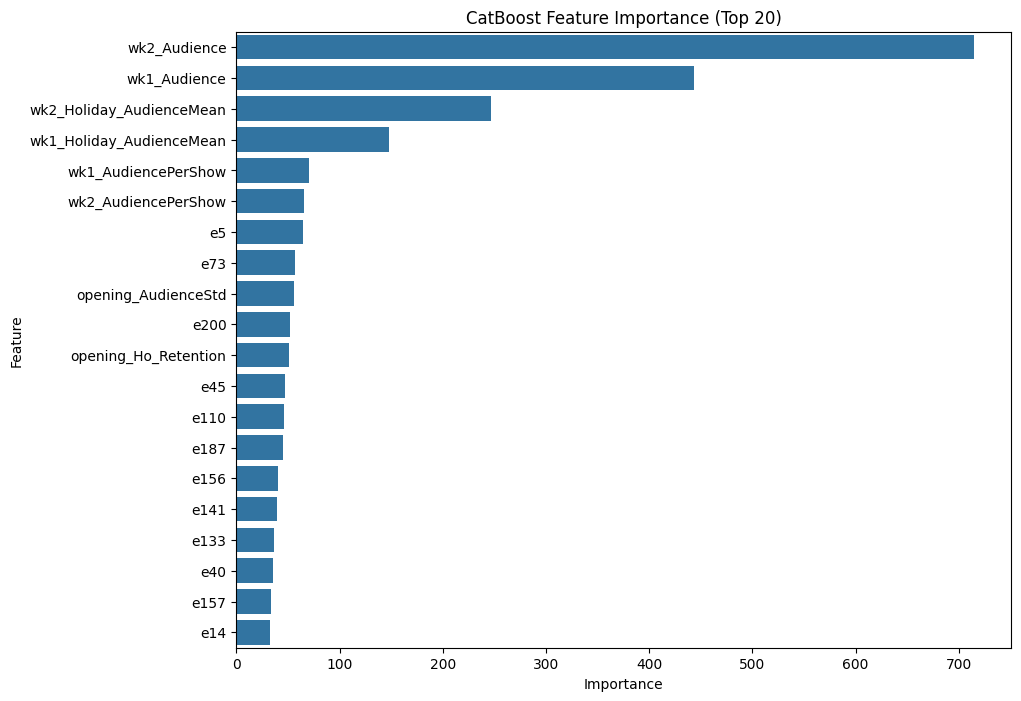

                      Feature  Importance
2                wk2_Audience         715
0                wk1_Audience         443
8    wk2_Holiday_AudienceMean         247
6    wk1_Holiday_AudienceMean         148
1         wk1_AudiencePerShow          70
3         wk2_AudiencePerShow          66
24                         e5          65
92                        e73          57
10        opening_AudienceStd          56
219                      e200          52
5        opening_Ho_Retention          51
64                        e45          47
129                      e110          46
206                      e187          45
175                      e156          40
160                      e141          39
152                      e133          37
59                        e40          36
176                      e157          34
33                        e14          33


In [ ]:
# 1. 변수 중요도 추출
feature_importances = model.feature_importances_
feature_names = X_train.columns

# 2. 데이터프레임으로 만들기
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 3. 상위 20개 변수 중요도 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('CatBoost Feature Importance (Top 20)')
plt.show()

# 4. 중요도 출력
print(importance_df.head(20))

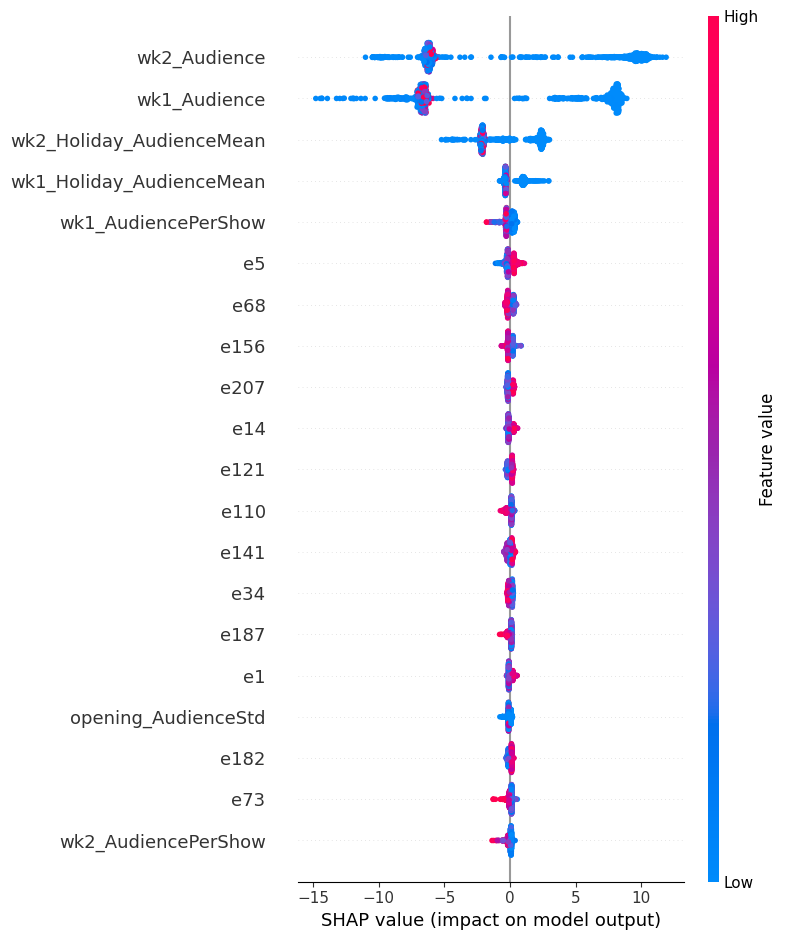

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

1. `wk1_Audience`, `wk2_Audience`, `wk2_Holiday_AudienceMean`, `wk1_Holiday_AudienceMean`
2. `wk1_AudiencePerShow`, `wk2_AudiencePerShow`
3. `opening_AudienceStd`, `opening_Ho_Retention`

총 4+2+2개의 변수가 유의

## 변수 선택 하이퍼파라미터 튜닝

In [ ]:
feature_sets = {
    "base_4": ['wk1_Audience', 'wk2_Audience', 'wk1_Holiday_AudienceMean', 'wk2_Holiday_AudienceMean'],
    "medium_6": ['wk1_Audience', 'wk2_Audience', 'wk1_Holiday_AudienceMean', 'wk2_Holiday_AudienceMean',
                 'wk1_AudiencePerShow', 'wk2_AudiencePerShow'],
    "full_8": ['wk1_Audience', 'wk2_Audience', 'wk1_Holiday_AudienceMean', 'wk2_Holiday_AudienceMean',
                 'wk1_AudiencePerShow', 'wk2_AudiencePerShow',
                'opening_AudienceStd', 'opening_Ho_Retention']
}

embedding_sets = {
    "embed_128": [f'e{i+1}' for i in range(128)],
    "embed_64": [f'e{i+1}' for i in range(64)],
    "embed_32": [f'e{i+1}' for i in range(32)],
    "embed_none" : []
}

tuner_methods = ['optuna', 'random_search']
# tuner_methods = ['random_search', 'optuna']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgb
import optuna
from scipy.stats import uniform, randint
import warnings


# --- 실험 루프 ---
results = []
experiment_id = 0
total_experiments = len(feature_sets) * len(embedding_sets) * len(tuner_methods)

for f_name, f_cols in feature_sets.items():
    for e_name, e_cols in embedding_sets.items():

        # 현재 조합에 사용할 전체 변수 리스트 생성
        current_cols = f_cols + e_cols
        X_train_exp = X_train[current_cols].copy()
        X_test_exp = X_test[current_cols].copy()

        for tuner in tuner_methods:
            experiment_id += 1
            print(f"--- 실험 {experiment_id}/{total_experiments} 진행 중 ---")
            print(f"Features: {f_name}, Embeddings: {e_name}, Tuner: {tuner}")

            best_params = {}

            if tuner == 'optuna':
                def objective(trial):
                    param_optuna = {
                        'objective': 'binary',
                        'metric': 'binary_logloss',
                        'n_estimators': 300,
                        'verbose': -1,
                        'device': 'gpu',
                        'gpu_device_id': 0,

                        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
                        'max_depth': trial.suggest_int('max_depth', 4, 10),
                        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
                        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                    }
                    model = lgb.LGBMClassifier(**param_optuna)
                    score = cross_val_score(model, X_train_exp, y_train, cv=3, scoring='f1_macro').mean()
                    return score

                study = optuna.create_study(direction='maximize')
                study.optimize(objective, n_trials=40, show_progress_bar=True)
                best_params = study.best_params

            elif tuner == 'random_search':
                param_random = {
                    'learning_rate': uniform(0.01, 0.29),
                    'num_leaves': randint(20, 301),
                    'max_depth': randint(4, 11),
                    'subsample': uniform(0.6, 0.4),
                    'colsample_bytree': uniform(0.6, 0.4),
                    'reg_alpha': uniform(1, 9),
                    'reg_lambda': uniform(1, 9),
                    'min_child_samples': randint(5, 101),
                }
                model = lgb.LGBMClassifier(objective='binary', n_estimators=300, verbose=-1, device='gpu', gpu_device_id=0)
                random_search = RandomizedSearchCV(
                    model,
                    param_distributions=param_random,
                    n_iter=40,
                    cv=3,
                    scoring='f1_macro',
                    random_state=42,
                    verbose=1,
                )
                random_search.fit(X_train_exp, y_train)
                best_params = random_search.best_params_

            # 찾은 최적의 파라미터로 최종 모델 학습
            print(f"{f_name} - {e_name} - {tuner} 최종 모델 학습")
            final_model = lgb.LGBMClassifier(
                objective='binary',
                n_estimators=1000,
                device='gpu',
                gpu_device_id=0,
                **best_params
            )
            # fit 할 때 로그 출력 설정 (callbacks)
            final_model.fit(X_train_exp, y_train, callbacks=[lgb.log_evaluation(period=200)])

            # 테스트 데이터로 성능 평가
            preds = final_model.predict(X_test_exp)
            f1 = f1_score(y_test, preds, average='macro')
            accuracy = accuracy_score(y_test, preds)

            # 결과 저장
            results.append({
                "Experiment_ID": experiment_id,
                "Feature_Set": f_name,
                "Embedding_Set": e_name,
                "Tuner": tuner,
                "Test_F1_Macro": f1,
                "Test_Accuracy": accuracy,
                "Best_Params": best_params
            })
            print(f"결과 - F1 Macro: {f1:.4f}, Accuracy: {accuracy:.4f}\n")

            # (메모리 정리 블록은 필요시 여기에 추가)

--- 실험 1/24 진행 중 ---
Features: base_4, Embeddings: embed_128, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_4 - embed_128 - optuna 최종 모델 학습
결과 - F1 Macro: 0.9716, Accuracy: 0.9723

--- 실험 2/24 진행 중 ---
Features: base_4, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_4 - embed_128 - random_search 최종 모델 학습
결과 - F1 Macro: 0.9715, Accuracy: 0.9723

--- 실험 3/24 진행 중 ---
Features: base_4, Embeddings: embed_64, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_4 - embed_64 - optuna 최종 모델 학습
결과 - F1 Macro: 0.9715, Accuracy: 0.9723

--- 실험 4/24 진행 중 ---
Features: base_4, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_4 - embed_64 - random_search 최종 모델 학습
결과 - F1 Macro: 0.9738, Accuracy: 0.9746

--- 실험 5/24 진행 중 ---
Features: base_4, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_4 - embed_32 - optuna 최종 모델 학습
결과 - F1 Macro: 0.9749, Accuracy: 0.9757

--- 실험 6/24 진행 중 ---
Features: base_4, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_4 - embed_32 - random_search 최종 모델 학습
결과 - F1 Macro: 0.9738, Accuracy: 0.9746

--- 실험 7/24 진행 중 ---
Features: base_4, Embeddings: embed_none, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

base_4 - embed_none - optuna 최종 모델 학습
결과 - F1 Macro: 0.9669, Accuracy: 0.9679

--- 실험 8/24 진행 중 ---
Features: base_4, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
base_4 - embed_none - random_search 최종 모델 학습
결과 - F1 Macro: 0.9738, Accuracy: 0.9746

--- 실험 9/24 진행 중 ---
Features: medium_6, Embeddings: embed_128, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_128 - optuna 최종 모델 학습
결과 - F1 Macro: 0.9716, Accuracy: 0.9723

--- 실험 10/24 진행 중 ---
Features: medium_6, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_128 - random_search 최종 모델 학습
결과 - F1 Macro: 0.9738, Accuracy: 0.9746

--- 실험 11/24 진행 중 ---
Features: medium_6, Embeddings: embed_64, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_64 - optuna 최종 모델 학습
결과 - F1 Macro: 0.9726, Accuracy: 0.9735

--- 실험 12/24 진행 중 ---
Features: medium_6, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_64 - random_search 최종 모델 학습
결과 - F1 Macro: 0.9772, Accuracy: 0.9779

--- 실험 13/24 진행 중 ---
Features: medium_6, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_32 - optuna 최종 모델 학습
결과 - F1 Macro: 0.9727, Accuracy: 0.9735

--- 실험 14/24 진행 중 ---
Features: medium_6, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_32 - random_search 최종 모델 학습
결과 - F1 Macro: 0.9715, Accuracy: 0.9723

--- 실험 15/24 진행 중 ---
Features: medium_6, Embeddings: embed_none, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

medium_6 - embed_none - optuna 최종 모델 학습
결과 - F1 Macro: 0.9738, Accuracy: 0.9746

--- 실험 16/24 진행 중 ---
Features: medium_6, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
medium_6 - embed_none - random_search 최종 모델 학습
결과 - F1 Macro: 0.9727, Accuracy: 0.9735

--- 실험 17/24 진행 중 ---
Features: full_8, Embeddings: embed_128, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_8 - embed_128 - optuna 최종 모델 학습
결과 - F1 Macro: 0.9738, Accuracy: 0.9746

--- 실험 18/24 진행 중 ---
Features: full_8, Embeddings: embed_128, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_8 - embed_128 - random_search 최종 모델 학습
결과 - F1 Macro: 0.9761, Accuracy: 0.9768

--- 실험 19/24 진행 중 ---
Features: full_8, Embeddings: embed_64, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_8 - embed_64 - optuna 최종 모델 학습
결과 - F1 Macro: 0.9726, Accuracy: 0.9735

--- 실험 20/24 진행 중 ---
Features: full_8, Embeddings: embed_64, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_8 - embed_64 - random_search 최종 모델 학습
결과 - F1 Macro: 0.9761, Accuracy: 0.9768

--- 실험 21/24 진행 중 ---
Features: full_8, Embeddings: embed_32, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_8 - embed_32 - optuna 최종 모델 학습
결과 - F1 Macro: 0.9726, Accuracy: 0.9735

--- 실험 22/24 진행 중 ---
Features: full_8, Embeddings: embed_32, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_8 - embed_32 - random_search 최종 모델 학습
결과 - F1 Macro: 0.9738, Accuracy: 0.9746

--- 실험 23/24 진행 중 ---
Features: full_8, Embeddings: embed_none, Tuner: optuna


  0%|          | 0/40 [00:00<?, ?it/s]

full_8 - embed_none - optuna 최종 모델 학습
결과 - F1 Macro: 0.9738, Accuracy: 0.9746

--- 실험 24/24 진행 중 ---
Features: full_8, Embeddings: embed_none, Tuner: random_search
Fitting 3 folds for each of 40 candidates, totalling 120 fits
full_8 - embed_none - random_search 최종 모델 학습
결과 - F1 Macro: 0.9749, Accuracy: 0.9757



In [ ]:
# --- 4. 최종 결과 취합 및 출력 ---
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='Test_F1_Macro', ascending=False)

print("========== 최종 실험 결과 (F1 Score 기준 정렬) ==========")
print(results_df_sorted)

========== 최종 실험 결과 (F1 Score 기준 정렬) ==========
    Experiment_ID Feature_Set Embedding_Set          Tuner  Test_F1_Macro  \
11             12    medium_6      embed_64  random_search       0.977215   
19             20      full_8      embed_64  random_search       0.976085   
17             18      full_8     embed_128  random_search       0.976066   
4               5      base_4      embed_32         optuna       0.974936   
23             24      full_8    embed_none  random_search       0.974917   
14             15    medium_6    embed_none         optuna       0.973827   
16             17      full_8     embed_128         optuna       0.973807   
5               6      base_4      embed_32  random_search       0.973807   
7               8      base_4    embed_none  random_search       0.973787   
3               4      base_4      embed_64  random_search       0.973787   
9              10    medium_6     embed_128  random_search       0.973787   
22             23      full_

## 최종 모델 생성

In [ ]:
# --- 5. 최고 성능 모델 재학습 및 저장 (LightGBM 버전) ---
print("\n========== 최고 성능 모델 재학습 및 저장 ==========")

# 5-1. 가장 점수가 높았던 실험의 설정 가져오기
best_experiment = results_df_sorted.iloc[0]
best_f_name = best_experiment['Feature_Set']
best_e_name = best_experiment['Embedding_Set']
best_params = best_experiment['Best_Params']

print(f"최고 성능 조합: Features='{best_f_name}', Embeddings='{best_e_name}'")
print(f"최고 성능 하이퍼파라미터: {best_params}")

# 5-2. 최고 성능 조합에 맞는 전체 데이터 준비
best_f_cols = feature_sets[best_f_name]
best_e_cols = embedding_sets[best_e_name]
best_current_cols = best_f_cols + best_e_cols

# 전체 데이터 X에서 최고 성능의 변수들만 선택
X_best_features = X[best_current_cols].copy() # .copy() 추가

# 5-3. 최고 성능 파라미터로 최종 모델 생성
best_model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=1000,
    device='gpu',
    gpu_device_id=0,
    **best_params
)

print("\n최고 성능 모델 전체 데이터로 재학습 시작...")
# 전체 데이터(X_best_features, y)로 최종 학습
best_model.fit(
    X_best_features,
    y,
    callbacks=[lgb.log_evaluation(period=200)] # verbose -> callbacks
)
print("재학습 완료.")

# 5-4. 모델 파일로 저장 (★★ LightGBM 핵심 부분 ★★)
# .booster_ 속성을 통해 LightGBM의 핵심 모델에 접근하여 저장합니다.
best_model.booster_.save_model("/content/drive/MyDrive/비어플/25-2/model/lightgbm_model_10k.txt")
print("최고 성능 모델을 'lightgbm_model_10k.txt' 파일로 저장했습니다. 💾")


========== 최고 성능 모델 재학습 및 저장 ==========
최고 성능 조합: Features='medium_6', Embeddings='embed_64'
최고 성능 하이퍼파라미터: {'colsample_bytree': np.float64(0.6592347719813599), 'learning_rate': np.float64(0.29934474066419314), 'max_depth': 6, 'min_child_samples': 6, 'num_leaves': 149, 'reg_alpha': np.float64(4.6993331198640815), 'reg_lambda': np.float64(1.2974565961049356), 'subsample': np.float64(0.7380284992106732)}

최고 성능 모델 전체 데이터로 재학습 시작...
재학습 완료.
최고 성능 모델을 'lightgbm_model_10k.txt' 파일로 저장했습니다. 💾
